In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import urllib
import json
import os
import contextily as ctx
import numpy as np
# import tensorflow as tf

from adjustText import adjust_text
from shapely.geometry import Polygon

In [2]:
from tensorflow.signal import rfft

# Getting Data

## Hydrological Data

The list of stations used by the Federal Office of the environment can be found on this page: https://www.bafu.admin.ch/bafu/de/home/themen/wasser/daten-karten/wasser--messnetze/basismessnetz--wasserstand-und-abfluss-an-oberflaechengewaessern.html#46775952

In [5]:
station_list = pd.read_excel("data/hydrology/Stationsliste_HydrowebSAM_DE_Juli2023.xlsx", skiprows=4)

# Restrict list to stations which are active, are part of the aare system and where discharge is measured
aare_stations = station_list[
    (station_list["Betriebsstatus"] == "in Betrieb") & 
    (station_list["Flussgebiet"] == "Aaregebiet") & 
    (station_list["Messparameter"]  == "Abfluss")
]

# convert to geopandas for ease of plot
aare_stations = gpd.GeoDataFrame(
    aare_stations,
    geometry=gpd.points_from_xy(x=aare_stations["X-Koordinate"], y=aare_stations["Y-Koordinate"]),
    crs='EPSG:2056'
)

aare_stations.head()

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

Choice (up for debate): Aare-Hagneck as target which has `Stationsnr. = 2085`

In [4]:
def get_catchment_geometry(station_no: str) -> gpd.GeoDataFrame | int:
    try:
        with urllib.request.urlopen(f"https://api3.geo.admin.ch/rest/services/api/MapServer/ch.bafu.hydrologie-hydromessstationen/{station_no}") as url:
            data = json.load(url)
            geometry = data.get('feature').get('geometry')
        # somewhat strong assumption: it seems, the geometry for all stations is defined as a ring - convert to shapely.Polygon
        catchment_geom = Polygon(geometry['rings'][0])
        catchment_geom = gpd.GeoDataFrame([{'geometry': catchment_geom}], crs="EPSG:21781") #EPSG:21781 the LV95 coordinate projection
        return catchment_geom
    except Exception as e:
        print(f"Something went wrong: {e}")
        return 0

catchment = get_catchment_geometry("2085")

In [5]:
# change the coordinate projection to the OpenStreetMap projection
catchment = catchment.to_crs(epsg=3857)
aare_stations = aare_stations.to_crs(epsg=3857)

# create a column whether a station is in catchment = is upriver 
aare_stations["in_catchment"] = aare_stations.geometry.apply(lambda geom: catchment.geometry[0].contains(geom))

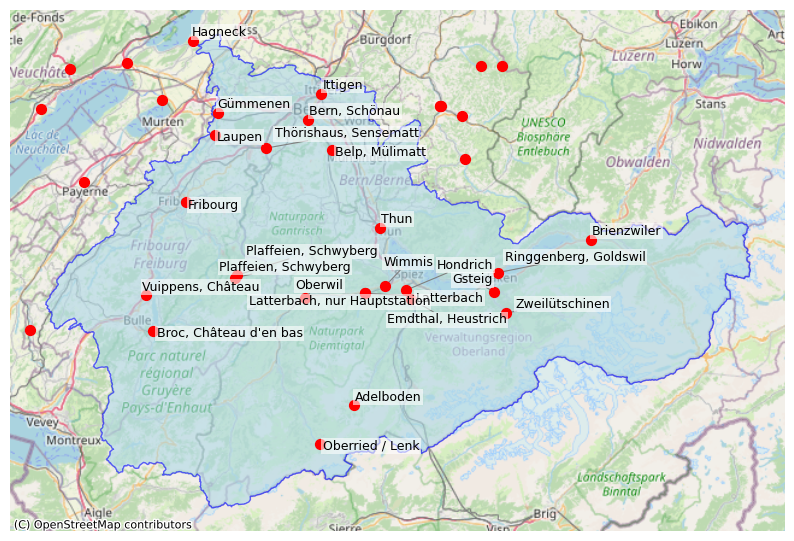

In [6]:
# Plot with map
fig, ax = plt.subplots(figsize=(10, 8))
catchment.plot(ax=ax, facecolor="lightblue", edgecolor="blue", alpha=0.6)

# Add basemap (OpenStreetMap tiles)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add hydrological stations and name those in catchment
aare_stations.plot(ax=ax, color="red", markersize=50, zorder=5)

texts = []
for idx, row in aare_stations[aare_stations["in_catchment"]==True].iterrows():
    texts.append(
        ax.text(
            row.geometry.x,
            row.geometry.y,
            row["Stationsname"],
            fontsize=9,
            color="black",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1),
            zorder=6
        )
    )

# Adjust positions to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="->", color="gray", lw=0.8))


ax.set_axis_off()
plt.show()

In [3]:
# Load data
hydro = pd.read_csv("data/hydrology/aare_2010.csv")
for year in np.arange(2011, 2025):
    tmp = pd.read_csv(f"data/hydrology/aare_{year}.csv")
    hydro = pd.concat([hydro, tmp])

# convert index to datetime
date_time = pd.to_datetime(hydro['timestamp'], format='%Y-%m-%d %H:%M:%S.000000 UTC')
hydro = hydro.set_index(date_time)

# convert to wide data frame
wide_hydro = hydro.pivot(index="timestamp", columns="station_no", values="value")

# convert column names to str
wide_hydro.columns = wide_hydro.columns.astype(str)

wide_hydro.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
station_no,,,,,,,,
2019,788976.0,36.893135,25.401705,2.213,16.802,30.3090,52.54100,367.108
2030,788976.0,111.646131,69.643343,24.948,56.587,91.8940,154.59400,499.180
2085,788976.0,168.991260,96.377453,17.592,98.677,151.3480,213.13100,1163.731
2109,788976.0,18.848872,17.321321,1.459,5.081,12.3350,29.14500,225.255
2135,788976.0,122.280430,71.774729,30.980,66.500,102.8145,163.25400,561.400
2159,788976.0,2.742226,3.134101,0.008,1.188,1.9330,3.10400,64.049
2160,788976.0,19.977767,20.385589,1.789,6.281,10.4340,28.55600,444.608
2179,788976.0,8.195178,9.975646,1.283,3.223,5.5150,9.05600,297.040
2215,788976.0,49.067556,48.117895,3.738,11.836,22.7040,82.77425,856.441


In [4]:
wide_hydro = wide_hydro.interpolate(method="linear")
wide_hydro.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
station_no,,,,,,,,
2019,788976.0,36.893135,25.401705,2.213,16.802,30.3090,52.54100,367.108
2030,788976.0,111.646131,69.643343,24.948,56.587,91.8940,154.59400,499.180
2085,788976.0,168.991260,96.377453,17.592,98.677,151.3480,213.13100,1163.731
2109,788976.0,18.848872,17.321321,1.459,5.081,12.3350,29.14500,225.255
2135,788976.0,122.280430,71.774729,30.980,66.500,102.8145,163.25400,561.400
2159,788976.0,2.742226,3.134101,0.008,1.188,1.9330,3.10400,64.049
2160,788976.0,19.977767,20.385589,1.789,6.281,10.4340,28.55600,444.608
2179,788976.0,8.195178,9.975646,1.283,3.223,5.5150,9.05600,297.040
2215,788976.0,49.067556,48.117895,3.738,11.836,22.7040,82.77425,856.441


### Seasonal cycle?

Does our target Hagneck show a clear seasonal cycle? To answer, let's perform a quick fourier transformation

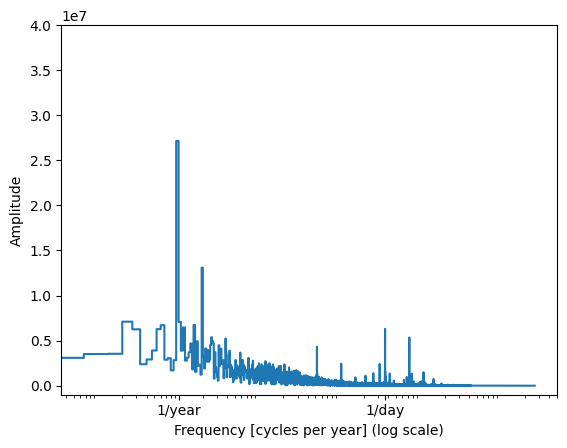

In [5]:

# Your series for station 2085
x = wide_hydro["2085"].values
n_samples = len(x)

# --- FFT ---
fft = rfft(x)

# --- Frequency axis ---
# Assume your data is hourly → sampling interval = 1 hour
dt = 1.0/6.0   # hours
freqs_per_hour = np.fft.rfftfreq(n_samples, d=dt)

# Convert to cycles per year (instead of per hour)
hours_per_year = 24 * 365.2524
freqs_per_year = freqs_per_hour * hours_per_year

# --- Plot ---
plt.step(freqs_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(-0.01e8, 0.4e8)
plt.xticks([1, 365.2524], labels=['1/year', '1/day'])
plt.xlabel("Frequency [cycles per year] (log scale)")
plt.ylabel("Amplitude")
plt.show()


Most pronounced cycle: ~1.00 years


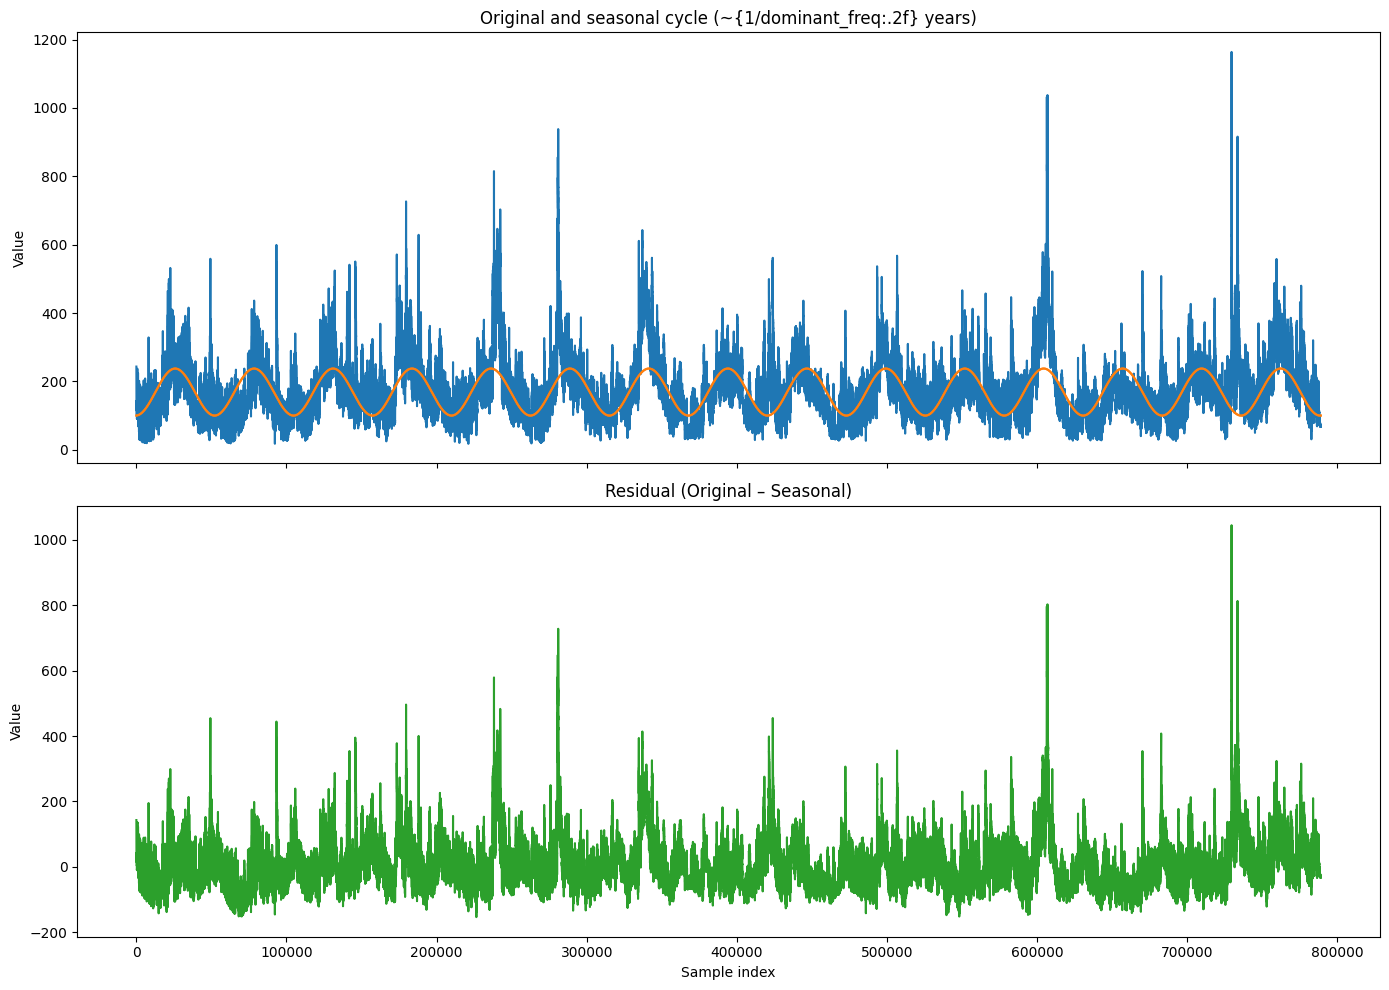

In [6]:
# --- Find dominant frequency ---
power = np.abs(fft)**2
dominant_idx = np.argmax(power[1:]) + 1
dominant_freq = freqs_per_year[dominant_idx]
print(f"Most pronounced cycle: ~{1/dominant_freq:.2f} years")

# --- Reconstruct seasonal component ---
fft_yearly = np.zeros_like(fft, dtype=complex)
fft_yearly[0] = fft[0]                         # keep mean
fft_yearly[dominant_idx] = fft[dominant_idx]   # keep strongest seasonal
seasonal = np.fft.irfft(fft_yearly, n=n_samples)

# --- Residual ---
residual = x - seasonal

# --- Subplots ---
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

axes[0].plot(x, color="C0")
axes[0].set_title("Original and seasonal cycle (~{1/dominant_freq:.2f} years)")
axes[0].plot(seasonal, color="C1")
axes[0].plot(seasonal, color="C1")

axes[1].plot(residual, color="C2")
axes[1].set_title("Residual (Original – Seasonal)")

for ax in axes:
    ax.set_ylabel("Value")
axes[-1].set_xlabel("Sample index")

plt.tight_layout()
plt.show()


In [7]:
# ensure DatetimeIndex
wide_hydro.index = pd.to_datetime(wide_hydro.index)
idx = wide_hydro.index  # DatetimeIndex

# day-of-year (1..366), seconds within the day, and days-in-year per timestamp
day_of_year = idx.dayofyear
seconds_of_day = idx.hour * 3600 + idx.minute * 60 + idx.second + idx.microsecond / 1e6
days_in_year = np.where(idx.is_leap_year, 366, 365)

# fractional position in that specific calendar year (0..1)
frac_of_year = ((day_of_year - 1) + seconds_of_day / 86400.0) / days_in_year

wide_hydro['year_sin'] = np.sin(2 * np.pi * frac_of_year)
wide_hydro['year_cos'] = np.cos(2 * np.pi * frac_of_year)


In [8]:
train_hydro = wide_hydro.loc['2019-01-01':'2023-12-31']
test_hydro = wide_hydro.loc['2024-01-01':]

y_train = train_hydro.pop("2085")
y_test = test_hydro.pop("2085")

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

steps = [
    ('scaler', StandardScaler()),
]
pipeline = Pipeline(steps)

hydro_train_prepared = pipeline.fit_transform(train_hydro)

In [10]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(hydro_train_prepared, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [11]:
# 1. Transform test data using the fitted pipeline
hydro_test_prepared = pipeline.transform(test_hydro)

# 2. Predict with the trained model
y_pred = lin_reg.predict(hydro_test_prepared)

# 3. Evaluate with MSE
rmse = (np.mean((y_test-y_pred)**2))**0.5
print("Mean Squared Error:", rmse)

Mean Squared Error: 36.546944721969574


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

steps = [
    ("scaler", StandardScaler()),
    ("lin_reg", LinearRegression())
]
pipeline = Pipeline(steps)

# Fit pipeline directly
pipeline.fit(train_hydro, y_train)

# Predict & evaluate
y_pred = pipeline.predict(test_hydro)
rmse = np.mean((y_test - y_pred)**2)**0.5
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 36.546944721969574


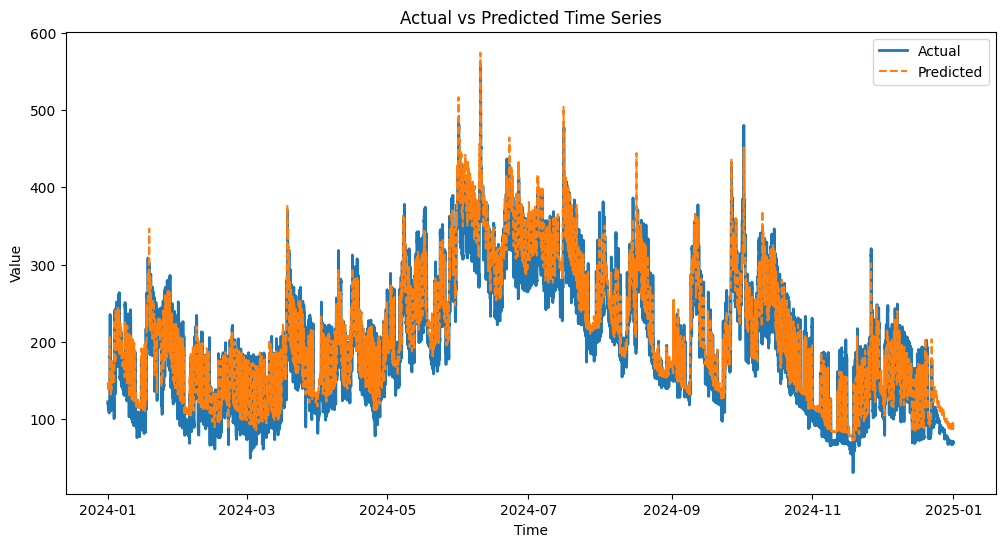

In [13]:
# Make sure y_pred is a pandas Series with the same index as y_test
y_pred_series = pd.Series(y_pred, index=y_test.index)

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(y_test.index, y_pred_series, label="Predicted", linestyle="--")

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Actual vs Predicted Time Series")
plt.legend()
plt.show()

### Simple linear regression - with time awareness

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class LagFeaturesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, n_lags=1):  # Set a default value for the hyperparameter
        self.n_lags = n_lags

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_with_lags = X.copy()

        # Create a list to store all the new lagged Series
        lagged_series_list = []
        
        # Iterate from 1 up to and including n_lags to create all desired lags
        for i in range(1, self.n_lags + 1):
            for col in X.columns:
                # Create a lagged Series and give it a descriptive name
                lagged_series = X[col].shift(periods=i)
                lagged_series.name = f'{col}_lag_{i}'
                lagged_series_list.append(lagged_series)

        # Concatenate all the new lagged Series with the original DataFrame
        X_with_lags = pd.concat([X] + lagged_series_list, axis=1)

        # This transformation introduces some NaN at the start as shift does not have a value present. To help
        # with this, we introduce a backwardsfill - copying the existing values backwards
        # While this makes the model worse, given ~260k rows, it should not be a big hinderance
        return X_with_lags.bfill()

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer

# Define the target station, lag, and seasonal features
target_station = '2085'
seasonal_features = ['sin_year', 'cos_year']
upstream_stations = [col for col in train_hydro.columns if col not in [target_station] + seasonal_features]

# Define the ColumnTransformer to handle different column types
numerical_pipeline = Pipeline([
    ('lag_adder', LagFeaturesAdder(n_lags=12)),
    ('scaler', StandardScaler())
])

# Define the ColumnTransformer
# Now, the 'lag_adder' step is replaced by the entire numerical_pipeline
# which will be applied to the upstream_stations.
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_features', numerical_pipeline, upstream_stations)
    ],
    remainder='passthrough'
)

# Create the final pipeline
regression_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Define the parameter grid to search
# 'preprocessor__lag_adder__n_lags' refers to the 'n_lags' parameter
# of the 'lag_adder' step, which is inside the 'preprocessor' step.
param_grid = {
    'preprocessor__numerical_features__lag_adder__n_lags': np.arange(0, 49, 6)
}

# Create and fit the GridSearchCV object
# cv=5 means 5-fold cross-validation
# n_jobs=-1 uses all available CPU cores for faster computation
grid_search = GridSearchCV(regression_pipeline, param_grid, cv=5, verbose=1, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(train_hydro, y_train)

# Print the best parameters and the best score
print("\nBest Parameters Found:")
print(grid_search.best_params_)
print("Best Cross-Validation Score (Negative Mean Squared Error):")
print(grid_search.best_score_)

# The best pipeline is now available as grid_search.best_estimator_
best_model = grid_search.best_estimator_
print("\nBest fitted model:")
print(best_model)

Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best Parameters Found:
{'preprocessor__numerical_features__lag_adder__n_lags': np.int64(12)}
Best Cross-Validation Score (Negative Mean Squared Error):
-258.68112141863486

Best fitted model:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_features',
                                                  Pipeline(steps=[('lag_adder',
                                                                   LagFeaturesAdder(n_lags=np.int64(12))),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['2019', '2030', '2109',
                                                   '2135', '2159', '2160',
                                                   '2179', '2215', '2232',
     

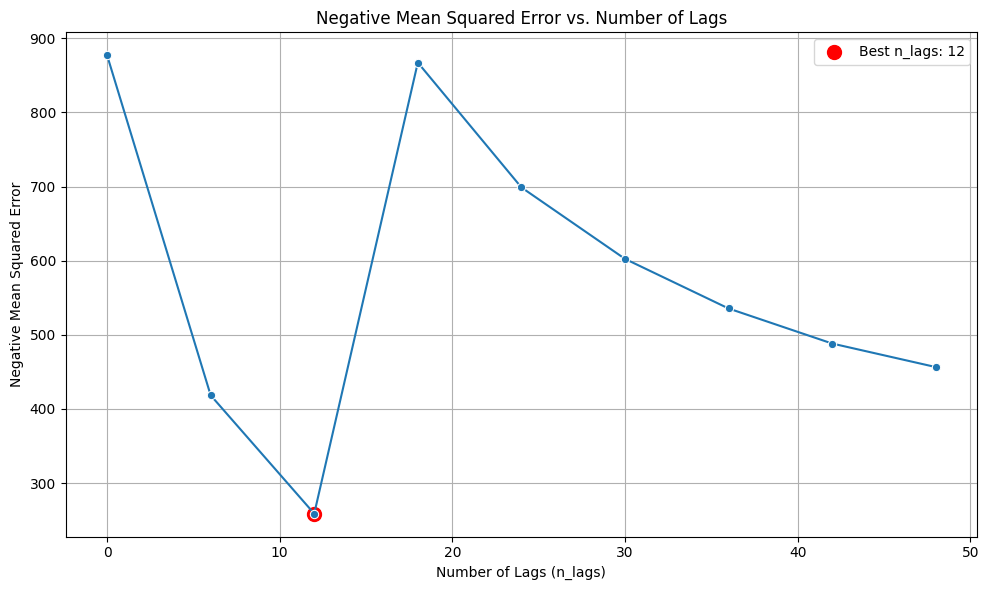

In [20]:
results = grid_search.cv_results_

n_lags = results['param_preprocessor__numerical_features__lag_adder__n_lags']
mean_score = results['mean_test_score']

results_df = pd.DataFrame({
    'n_lags': n_lags,
    'mean_test_score': -mean_score
})

best_n_lags = grid_search.best_params_['preprocessor__numerical_features__lag_adder__n_lags']
best_score = grid_search.best_score_

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='n_lags', y='mean_test_score', marker='o')
plt.scatter(best_n_lags, -best_score, color='red', s=100, label=f'Best n_lags: {best_n_lags}')

# Set plot title and labels
plt.title('Negative Mean Squared Error vs. Number of Lags')
plt.xlabel('Number of Lags (n_lags)')
plt.ylabel('Negative Mean Squared Error')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [21]:
y_pred = best_model.predict(test_hydro)
rmse = np.mean((y_test - y_pred)**2)**0.5
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 16.531827817056506


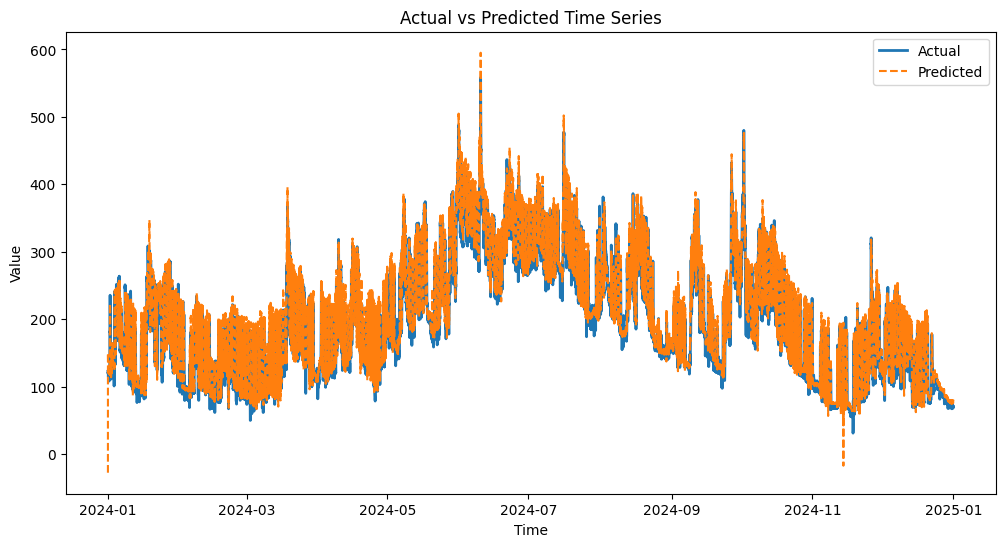

In [22]:
# Make sure y_pred is a pandas Series with the same index as y_test
y_pred_series = pd.Series(y_pred, index=y_test.index)

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(y_test.index, y_pred_series, label="Predicted", linestyle="--")

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Actual vs Predicted Time Series")
plt.legend()
plt.show()

In [23]:
import pickle

# Access the best-performing model from your grid search
best_model = grid_search.best_estimator_

# Define the file path for saving the model
model_filepath = 'best_hydro_regression_model_with_lag.pkl'

# Save the model to a file
with open(model_filepath, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Model successfully saved to {model_filepath}")

Model successfully saved to best_hydro_regression_model_with_lag.pkl


In [ ]:
import pickle

# Define the file path for the saved model
model_filepath = 'best_hydro_regression_model.pkl'

# Load the model from the file
with open(model_filepath, 'rb') as file:
    loaded_model = pickle.load(file)

print("Model successfully loaded.")
print(loaded_model)

# You can now use the loaded model to make new predictions
# loaded_model.predict(new_data)

## Meteorological stations

In [49]:
meteo_stations = pd.read_csv("https://data.geo.admin.ch/ch.meteoschweiz.ogd-smn-precip/ogd-smn-precip_meta_stations.csv", sep=';', encoding='latin-1')

meteo_stations = gpd.GeoDataFrame(
    meteo_stations,
    geometry=gpd.points_from_xy(x=meteo_stations.station_coordinates_lv95_east, y=meteo_stations.station_coordinates_lv95_north),
    crs='EPSG:2056'
)

meteo_stations = meteo_stations.to_crs(epsg=3857)

meteo_stations["in_catchment"] = meteo_stations.geometry.apply(lambda geom: catchment.geometry[0].contains(geom))

meteo_stations[meteo_stations['in_catchment']==True]

,station_abbr,station_name,station_canton,station_wigos_id,station_type_de,station_type_fr,station_type_it,station_type_en,station_dataowner,station_data_since,...,station_exposition_de,station_exposition_fr,station_exposition_it,station_exposition_en,station_url_de,station_url_fr,station_url_it,station_url_en,geometry,in_catchment
13,BEP,Belp,BE,0-756-0-BEP,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,MeteoSchweiz,01.01.1901,...,Ebene,Plaine,Pianura,plain,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (835490.081 5926760.134),True
36,GAD,Gadmen,BE,0-756-0-GAD,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,"Kt. BE, SLF",28.07.1911,...,Tal,Vallée,Valle,valley,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (929644.886 5899228.06),True
39,GTT,Guttannen,BE,0-756-0-GTT,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,MeteoSchweiz,01.08.1876,...,Tal,Vallée,Valle,valley,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (923030.308 5886177.71),True
45,KAS,Kandersteg,BE,0-756-0-KAS,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,MeteoSchweiz,01.08.1899,...,Tal,Vallée,Valle,valley,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (854618.782 5859844.991),True
46,KIE,Kiental,BE,0-756-0-KIE,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,Kt. BE,01.01.1901,...,Tal,Vallée,Valle,valley,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (860176.756 5874205.088),True
47,KIS,Kiesen,BE,0-756-0-KIS,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,MeteoSchweiz,01.01.1972,...,Ebene,Plaine,Pianura,plain,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (843026.148 5912875.622),True
57,LTB,Lauterbrunnen,BE,0-756-0-LTB,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,MeteoSchweiz,01.08.1899,...,Osthang,Versant est,Versante orientale,eastern oriented slope,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (880143.514 5875880.573),True
139,ZWE,Zweisimmen,BE,0-756-0-ZWE,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,Kt. BE,01.01.1901,...,Tal,Vallée,Valle,valley,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.

In [62]:
# Downloading precipitation data now
download_url = [
    (f"https://data.geo.admin.ch/ch.meteoschweiz.ogd-smn-precip/{abr.lower()}/ogd-smn-precip_{abr.lower()}_t_historical_2010-2019.csv", abr) for abr in meteo_stations[meteo_stations["in_catchment"]]["station_abbr"]
]

path = os.path.join(os.path.curdir, 'data', 'meteorology')
for url, abr in download_url:
    try:
        df = pd.read_csv(url, sep=";")
        df.to_csv(os.path.join(path, f"{abr}.csv"))

    except Exception as e:
        print(f"An Issue with {abr} ({url}): {e}")
        continue

An Issue with GAD (https://data.geo.admin.ch/ch.meteoschweiz.ogd-smn-precip/gad/ogd-smn-precip_gad_t_historical_2010-2019.csv): HTTP Error 403: Forbidden
